# Dog vs Cat - data visualization

### Import

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

### Some global variables...

In [2]:
path_to_data = "D:\\fuel_data\\dogs_vs_cats\\train\\"
img_list = os.listdir(path_to_data)

### One random example

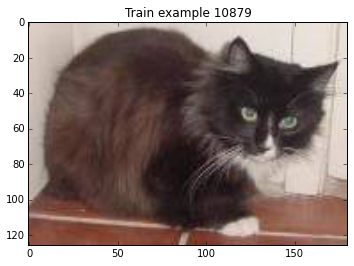

(126L, 180L, 3L)


In [3]:
n = np.random.randint(0,25000)
img = plt.imread(path_to_data+img_list[n])

plt.figure()
plt.title("Train example %d"%n)
plt.imshow(img)
plt.show()

print img.shape

### Quick overview

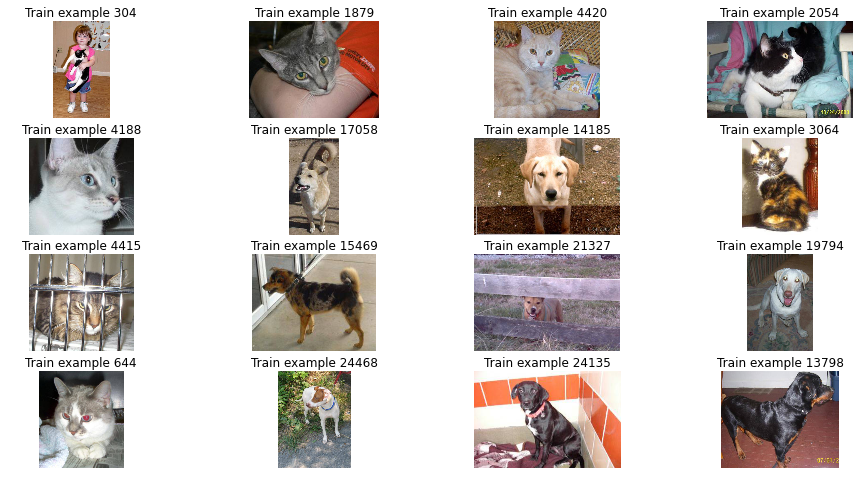

In [9]:
n = np.random.randint(0,25000,16)

plt.figure(figsize=(16,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.title("Train example %d"%n[i])
    img = plt.imread(path_to_data+img_list[n[i]])
    plt.axis("off")
    plt.imshow(img)
plt.show()

### Some statistics about images

In [10]:
width_histogram = []
height_histogram = []
i = 0
for name in img_list:
    img = plt.imread(path_to_data+name)
    width_histogram.append(img.shape[1])
    height_histogram.append(img.shape[0])
    print "\r%d"%i, 
    i += 1

24999


In [11]:
print "Mean width :", np.mean(width_histogram)
print "Mean height :", np.mean(height_histogram)

Mean width : 404.09904
Mean height : 360.47808


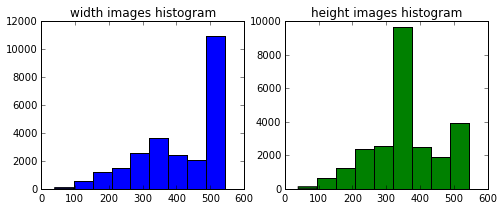

Mean width : 404.09904
Mean height : 360.47808


In [18]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.title("width images histogram")
plt.hist(width_histogram, range=(40,600))
plt.subplot(1,2,2)
plt.title("height images histogram")
plt.hist(height_histogram, range=(40,600), color="g")
plt.show()

print "Mean width :", np.mean(width_histogram)
print "Mean height :", np.mean(height_histogram)

## Data manipulation

### Convert to greyscale images

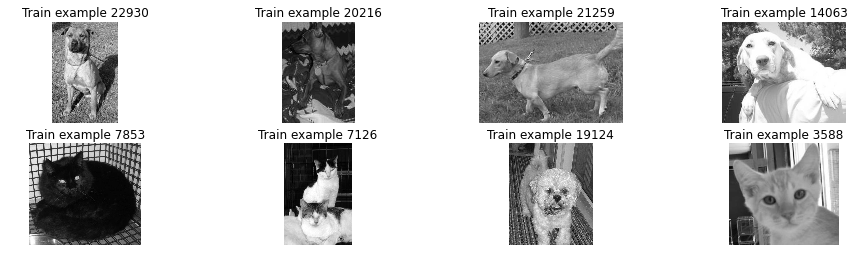

In [7]:
n = np.random.randint(0,25000,8)

plt.figure(figsize=(16,4))
plt.gray()
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.title("Train example %d"%n[i])
    img = cv2.imread(path_to_data+img_list[n[i]],0)
    plt.axis("off")
    plt.imshow(img)
plt.show()

### Resizing images to (64,64)

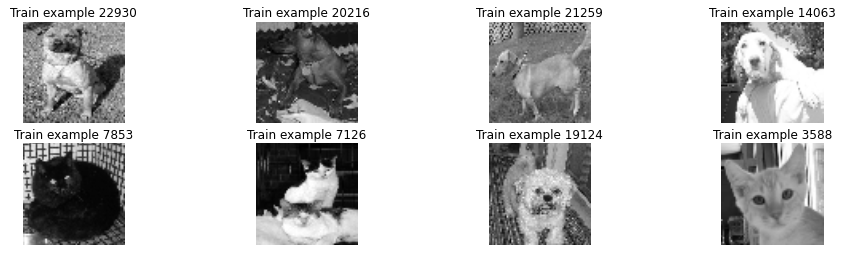

In [8]:
sz = (64,64)
plt.figure(figsize=(16,4))
plt.gray()
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.title("Train example %d"%n[i])
    img = cv2.imread(path_to_data+img_list[n[i]],0)
    resized_img = cv2.resize(img, sz, interpolation = cv2.INTER_CUBIC)
    plt.axis("off")
    plt.imshow(resized_img)
plt.show()

In [75]:
import PIL

def remove_black_borders_from_rotation(rotated_img, deg):
    
    if deg<0:
        out = remove_black_borders_from_rotation(rotated_img[:,::-1], -deg)
        return out[:,::-1]
    
    row, col = rotated_img.shape

    first_row = rotated_img[0]
    first_col = rotated_img[:,0]

    cropx = np.argwhere(np.cumsum(first_row[::-1]!=0)==1)[0][0]
    cropy = np.argwhere(np.cumsum(first_col!=0)==1)[0][0]
    
    return rotated_img[cropy:(row-cropy), cropx:(col-cropx)]

def remove_black_borders_from_translation(translated_img, tx, ty):
    
    row, col = translated_img.shape
    
    left = max(0,tx)
    right = min(col,col+tx)
    up = max(0,ty)
    down = min(row,row+ty)
    
    return translated_img[up:down, left:right]

def rotate(img, angle):
    # if img.ndim > 2:
    #     print "Rotate only works for gray image."
    # rows,cols = img.shape
    # M = cv2.getRotationMatrix2D((cols/2,rows/2), angle, 1)
    # return cv2.warpAffine(img, M,(cols,rows))
    pil_img = PIL.Image.fromarray(img)
    return np.array(pil_img.rotate(angle), dtype=img.dtype)

def crop(img, crop_rates):
    rows,cols = img.shape
    crop_up, crop_down, crop_left, crop_right = crop_rates
    crop_up = int(crop_up*rows/100.0)
    crop_down = int(crop_down*rows/100.0)
    crop_left = int(crop_left*rows/100.0)
    crop_right = int(crop_right*rows/100.0)
    return img[crop_up:(rows-crop_down),crop_left:(cols-crop_right)]

def resize_and_scale(img, size, scale, interpolation = cv2.INTER_CUBIC):
    img = cv2.resize(img, size, interpolation=interpolation)
    return np.array(img, "float32")/scale

In [80]:
def rotate_crop_and_scale(img, final_size, max_angle, max_crop_rate, scale):
    # Random Rotation
    angle = np.random.randint(-max_angle,max_angle)
    rotated_img = rotate(img, angle)
    # Remove black borders
    cropped_rotated_img = remove_black_borders_from_rotation(rotated_img, angle)
    # Random Crop
    crop_rates = np.random.randint(0, max_crop_rate, 4) # translation rates
    cropped_im = crop(cropped_rotated_img, crop_rates)
    # Resize and scale
    #try:
    resized_img = resize_and_scale(cropped_im, final_size, scale, interpolation=cv2.INTER_CUBIC)
    #except: # sometimes i get an error when resizing with open cv (ssize.area < 0 error)
    #    resized_img = np.zeros(final_size, dtype="float32")
    # Flip left right
    if np.random.randint(0,2)==1:
        resized_img = np.fliplr(resized_img)
    output_img = resized_img[None,:,:]
    # Return
    return output_img, cropped_im, cropped_rotated_img, rotated_img, angle

def display_process(str_file, sz=(100,100)): 
    img = cv2.imread(str_file)
    gray_img = cv2.imread(str_file, 0)
    output_img, cropped_im, cropped_rotated_img, rotated_img, angle = rotate_crop_and_scale(gray_img, sz, 10, 10, 255.0)
    # DISPLAY
    plt.figure(figsize=(16,10))
    plt.subplot(2,3,1)
    plt.axis("off")
    plt.title("Raw (%dx%d)"%(img.shape[0],img.shape[1]))
    plt.imshow(img, interpolation="nearest")
    plt.subplot(2,3,2)
    plt.gray()
    plt.axis("off")
    plt.title("Gray")
    plt.imshow(gray_img, interpolation="nearest")
    plt.subplot(2,3,3)
    plt.axis("off")
    plt.title("Rotated (%d deg)"%angle)
    plt.imshow(rotated_img, interpolation="nearest")
    plt.subplot(2,3,4)
    plt.axis("off")
    plt.title("Without black border")
    plt.imshow(cropped_rotated_img, interpolation="nearest")
    plt.subplot(2,3,5)
    plt.axis("off")
    plt.title("Random crop")
    plt.imshow(cropped_im, interpolation="nearest")
    plt.subplot(2,3,6)
    plt.axis("off")
    plt.title("Final image")
    plt.imshow(output_img[0], interpolation="nearest")
    plt.show()
    
    print output_img.shape

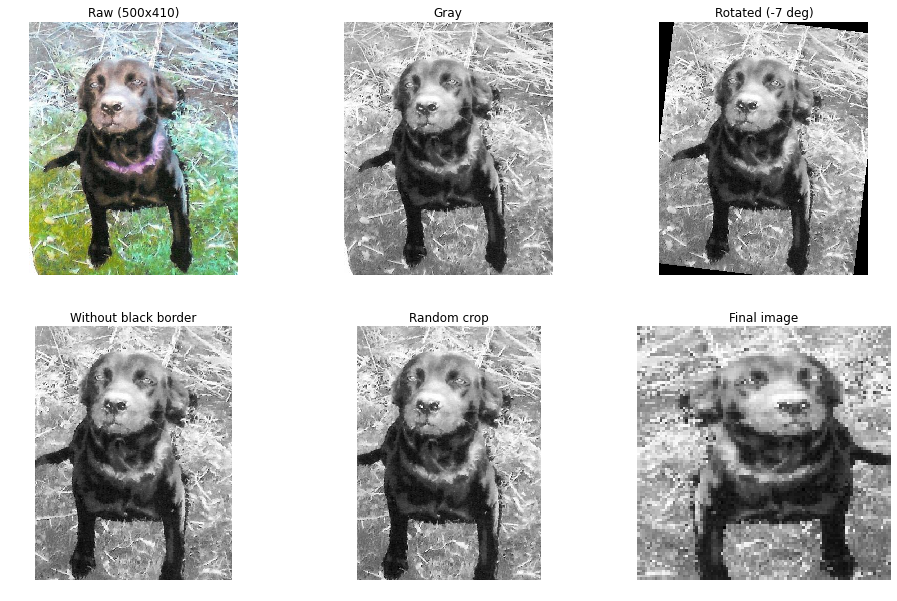

(1L, 100L, 100L)


In [81]:
n = np.random.randint(0,25000,1)[0]
display_process(path_to_data+img_list[n], sz=(100,100))

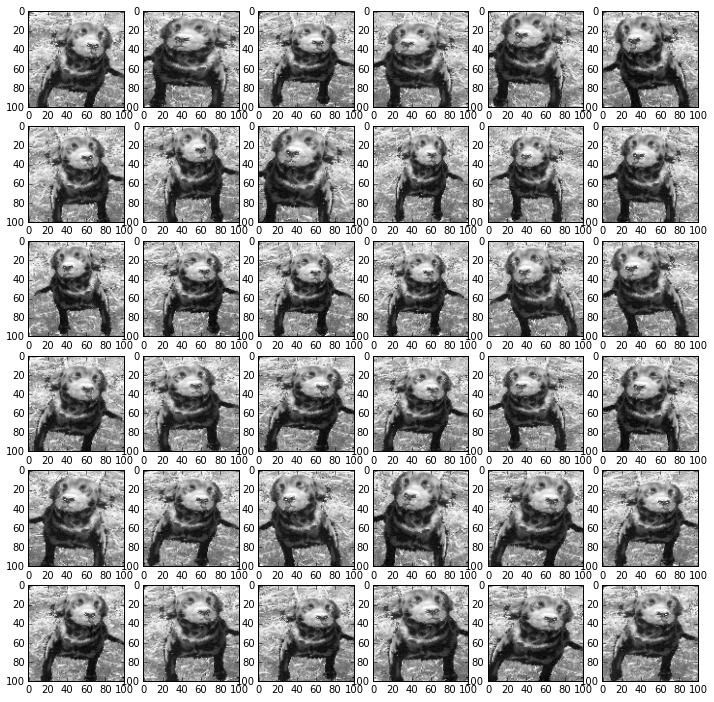

In [83]:
gray_img = cv2.imread(path_to_data+img_list[n], 0)
plt.figure(figsize=(12,12))
for i in range(6*6):
    plt.subplot(6,6,i+1)
    imgs = rotate_crop_and_scale(gray_img, (100,100), 10, 10, 255.0)
    plt.imshow(imgs[0][0])
plt.show()

# Data Train and Data Valid

### Dividing the dataset into a trainset and a validationset

In [60]:
np.random.seed(123456)
index = np.arange(0,25000,1)
np.random.shuffle(index)

In [64]:
img_list = np.array(img_list)
train_list = img_list[index[0:20000]] # 20000 train examples
valid_list = img_list[index[20000:25000]] # 5000 valid examples

# Targets
targets = np.zeros((25000,2))
targets[0:12500,0]=1.0
targets[12500:25000,1]=1.0
train_targets = targets[index[0:20000]]
valid_targets = targets[index[20000:25000]]

### Create and store the Trainset

In [107]:
final_size = (100,100)
# Instantiate train data
train_data = np.zeros((20000, final_size[0], final_size[1]), dtype="float32")
# Fill it
for i, name in enumerate(train_list):
    train_example = preprocess(path_to_data+name, final_size)
    train_data[i] = train_example
    print "\r%d examples processed"%(i+1),

20000 examples processed


In [108]:
import cPickle
description = "Training data. Rotation : +- 10 deg. Translation rate : +-15. Norm : (x - mean(x))/128.0"
with open('D:\\fuel_data\\dogs_vs_cats\\train_data_2016_01_31.pkl', 'w') as f:
    cPickle.dump(train_data, f)
    cPickle.dump(description, f)

In [109]:
del train_data

### Create and store the Validationset

In [111]:
# Instantiate valid data
valid_data = np.zeros((5000, final_size[0], final_size[1]), dtype="float32")
# Fill it
for i, name in enumerate(valid_list):
    valid_example = preprocess(path_to_data+name, final_size)
    valid_data[i] = valid_example
    print "\r%d examples processed"%(i+1),

5000 examples processed


In [112]:
description = "Valid data. Rotation : +- 10 deg. Translation rate : +-15. Norm : (x - mean(x))/128.0"
with open('D:\\fuel_data\\dogs_vs_cats\\valid_data_2016_01_31.pkl', 'w') as f:
    cPickle.dump(valid_data, f)
    cPickle.dump(description, f)

In [1]:
import cPickle
with open('D:\\fuel_data\\dogs_vs_cats\\train_data_2016_01_31.pkl', 'r') as f:
    train_data = cPickle.load(f)
    description = cPickle.load(f)

MemoryError: 

In [2]:
def wrapper1(func, *args): # with star
    func(*args)

def wrapper2(func, args): # without star
    func(*args)

def func2(x, y, z):
    print x+y+z

wrapper1(func2, 1, 2, 3)
wrapper2(func2, [1, 2, 3])

6
6
